## Introduction

We want to be able to indentify legendary pokemon based on type, stats, and generation. This will be a binary classification problem.

In [465]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [466]:
data = pd.read_csv('Pokemon.csv')

In [467]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [468]:
# lets standardize the column names
data.columns = [col.lower()
                   .replace(".","") 
                   .replace(" ", "_")
                for col in data.columns]

# how much of the data is legendaries?
data['legendary'].sum() / data.shape[0]

0.08125

## <u>Preprocessing</u>
### Stratified Sampling

Since the positive class (being legendary) is rare, let's use a stratified sampling method

In [469]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=23)
for train_index, test_index in split.split(data, data['legendary']):
    train = data.loc[train_index]
    test = data.loc[test_index]

### Data Cleaning

In [470]:
# removing mega evolutions
train = train[train['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] # "Mega" is typically after a word
test = test[test['name'].apply(lambda col: True if not re.search('\wMega',col) else False)] # "Mega" is typically after a word

In [471]:
# remove useless columns
train = train.drop(['#', 'name'], axis = 1)
test = test.drop(['#', 'name'], axis = 1)

In [472]:
# make the generation into an object type
train['generation'] = train['generation'].astype(str)
test['generation'] = test['generation'].astype(str)

In [473]:
# total, by definition is colinear with other stats
train = train.drop('total', axis = 1)
test = test.drop('total', axis = 1)

### Exploration

Since mega-evolutions are gone, let's do some exploratory analysis.

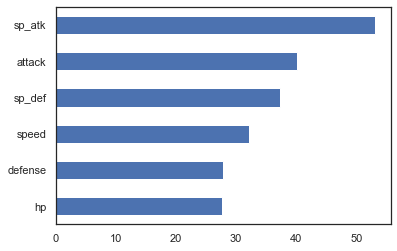

In [474]:
train.pivot_table(index='legendary', values=['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed'], aggfunc=np.mean) \
     .apply(lambda row: row[True] - row[False], axis=0) \
     .sort_values() \
     .plot.barh()

We see that on average, most legendary pokemon have much higher sp_atk that regular pokemon.

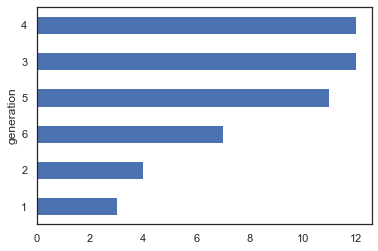

In [475]:
train.pivot_table(index='generation', values=['legendary'], aggfunc=np.sum)\
     .sort_values(by='legendary')\
     .plot.barh(legend=False)

A couple generations have more legendaries, but it's not that much.

### Column Transformation
#### Type Indicator
We want to make sure that the model doesn't care if a type is type1 or type2 if it's the same type. This will also reduce 
34 dummy columns for type to 17.

In [476]:
# get all the unique types
types = set(np.concatenate((train['type_1'].unique(), 
                            train['type_2'].dropna().unique()))) # get all the types in the train and test
types = list(types)

# make a column for each type on the train and test set
for type_ in types:
    dummy_col = type_.lower() + "_ind"
    train[dummy_col] = train.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)

for type_ in types:
    dummy_col = type_.lower() + "_ind"
    test[dummy_col] = test.apply(lambda row: 1 if row['type_1'] == type_ or row['type_2'] == type_ else 0, axis = 1)
    
# we can drop the type columns now
train = train.drop(['type_1', 'type_2'], axis = 1)
test = test.drop(['type_1', 'type_2'], axis = 1)    

#### One-hot Encoding 

In [477]:
def create_dummies(df, column_name, drop = True):
    
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    if drop:
        df = df.drop(column_name, axis = 1)
    
    return df

In [478]:
train = create_dummies(train, "generation")
test = create_dummies(test, "generation")

Let's see which specific stats legendary pokemon are higher in than regular pokemon.

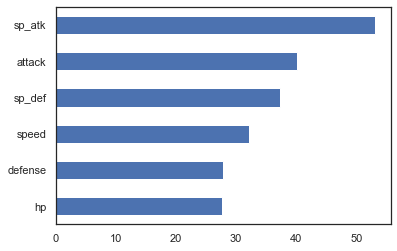

In [479]:
train.pivot_table(index='legendary', values=['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed'], aggfunc=np.mean) \
     .apply(lambda row: row[True] - row[False], axis=0) \
     .sort_values() \
     .plot.barh()

Legendary typically have much stronger sp_atk than regular pokemon.

In [480]:
def plot_correlation_heatmap(df):
    
    corr = df.corr()
    sns.set(style = 'white')
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (11, 9))
    cmap = sns.diverging_palette(10, 150, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
                square= True, linewidth = .5, cbar_kws = {'shrink':.5})
    plt.show()

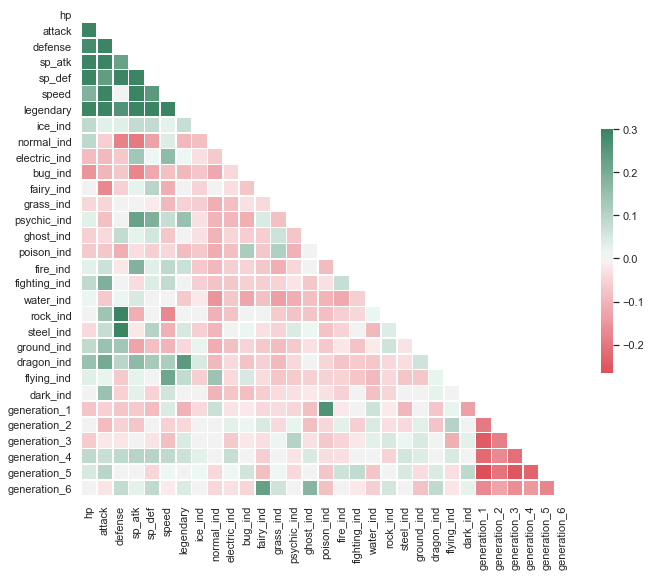

In [481]:
plot_correlation_heatmap(train)

**Insights:**

We see that typically as one type increases, so do the others. The only one that don't predict eachother that well is speed and defense.

Being dragon or psychic is a strong indicator that pokemon might be legendary.

The fighting feature could be deleted since it hardly predicts legendary status and is strongly correlated with the attack feature.

The same could be said about fairy and the sp def stat and just being gen 6

Normal and bug can be taken out too since it's typically not represent with any other type.

We may be able to remove sp atk and defense since they're correlated with other types too.

generations are weak indicators of legendaries, and we saw that they're isn't many legendaries per generation to begin with.

In [482]:
# based on our insights, let's drop the generation features
train = train.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)
test = test.drop(['generation_1', 'generation_2', 'generation_3', 'generation_4', 'generation_5', 'generation_6'], axis=1)

# getting rid of the generations helped alot

train = train.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 
                    'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 'ghost_ind', 'water_ind', 'steel_ind'], axis=1)

test = test.drop(['fairy_ind', 'rock_ind', 'fighting_ind', 
                  'electric_ind', 'bug_ind', 'normal_ind', 'grass_ind', 'ghost_ind', 'water_ind', 'steel_ind'], axis=1)

# getting rid of the types didn't help much from the generations removal


train = train.drop(['dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 'ground_ind', 'fire_ind'], axis=1)

test = test.drop(['dark_ind', 'ice_ind', 'poison_ind', 'flying_ind', 'ground_ind', 'fire_ind'], axis=1)
# with getting rid of most of the types above, we achieve a R/C curve of 95/78

# turn the above into one drop statement

In [483]:
# splitting the features and labels
X_train = train.drop('legendary', axis = 1)
X_test = test.drop('legendary', axis = 1)

y_train = train['legendary'] 
y_test = test['legendary'] 

## <u>Modeling

In [493]:
from sklearn.linear_model import LogisticRegression

In [494]:
lr = LogisticRegression()

In [495]:
lr.fit(X_train, y_train)

LogisticRegression()

In [496]:
preds = lr.predict(X_test)

In [497]:
# Let's take a quick look at the accuracy score, even though it's misleading
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9722222222222222

In [498]:
# we can use this too
lr.score(X_test, y_test) 

0.9722222222222222

### Decision Scores

Since we'll like to maximize the recall and precision of the our model, let's find the decision scores of our model.

In [499]:

from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(lr, X_train, y_train, cv = 3,
                             method = 'decision_function')

### Precision-Recall Curve

We decide to use this curve since the positive class (i.e. legendary pokemon) are rare.

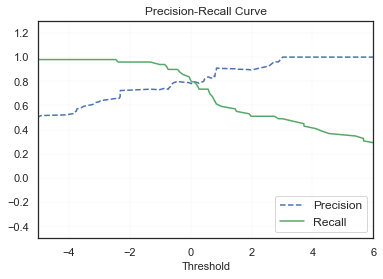

In [500]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="lower right", fontsize=12)
    plt.xlabel("Threshold", fontsize=11)        
    plt.grid(True, linewidth=.1)                             
    plt.axis([-5, 6, -.5, 1.3])
    plt.title("Precision-Recall Curve", loc="center")
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [492]:
# let's see this in a tabular format
names = ["precision", "recall", "thresholds"]
prt_dict = {name:nums for name, nums in zip(names, [precisions[:-1], recalls[:-1], thresholds])}
prt_df = pd.DataFrame(prt_dict)
prt_df[prt_df["recall"].between(.78,.96)]  # this is the recall range we're interested in, based on the curve above.

,precision,recall,thresholds
57,0.652778,0.959184,-2.388694
58,0.661972,0.959184,-2.365327
59,0.712121,0.959184,-2.231215
60,0.723077,0.959184,-2.151678
61,0.734375,0.959184,-1.202316
62,0.730159,0.938776,-0.982606
63,0.741935,0.938776,-0.750079
64,0.737705,0.918367,-0.726257
65,0.750000,0.918367,-0.694412
66,0.762712,0.918367,-0.681883


We decide that the threshold of -0.648266 is best since it'll keep the recall around around 80%, while keeping the precision relatively high. 

#### Testing and Setting the new Threshold

In [442]:
from sklearn.metrics import precision_score, recall_score

new_pred = y_scores >= -0.426808

print(f'precision score: {precision_score(y_train, new_pred)}\n\
   recall score: {recall_score(y_train, new_pred)}')

precision score: 0.7962962962962963
   recall score: 0.8775510204081632


### Test Set

In [443]:
test_preds = lr.decision_function(X_test) >= -0.426808

print(f'precision score: {precision_score(y_test, test_preds)}\n\
   recall score: {recall_score(y_test, test_preds)}')

precision score: 0.8181818181818182
   recall score: 0.9


In [444]:
features = list(X_train.columns)
coefs = list(lr.coef_[0])

pd.DataFrame({'features':features,
              'coefs':coefs}).sort_values(by=['coefs'], ascending=False)

,features,coefs
5,speed,0.152145
2,defense,0.125399
4,sp_def,0.121915
3,sp_atk,0.106241
1,attack,0.087178
0,hp,-0.006368
6,psychic_ind,-0.491459
7,dragon_ind,-0.884827


### Conclusion

We see that our performed better on the test set than on the training set. However, there's still a lot of volatility. On another run, there's a good chance that our precision/recall on the test would be worse.  Since only about 8% of pokemon are legendary, there's a good chance that many of the legendary pokemon that are outliers will (e.g. have lower stats) fall into one of the sets and not the other.

## Next Time:

see if you can make any actions from the exploration phase especially the correlation map.

see if you can make so that we can see which features predict being legendary the best.

By using the correlation map, we achieve around r/p of 90/79 which is good.

Next let's make a function where you can type in any pokeon name and we can see what the classifier thinks it is.

Maybe we can try using grid search, RCEV to see which features are best to keep.